In [ ]:
'''
LDA implementation using gensim
note: inital framework of code was dervived by
priya dwivedi https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb
Collaborators: DeAndre Tomlinson, Emmet Flynn, Paul Brunts
'''

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt
import os
import logging
import seaborn as sns
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'https', 'high', 'time', 
                    'table', 'read', 'number', 'also', 'show', 'elsevi',
                  ])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dtomlins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Functions:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [4]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [5]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [6]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
def stemWords(texts):
    ps = PorterStemmer()
    stemmed = [[ps.stem(word) for word in text] for text in texts]
    return stemmed

In [9]:
#Initializing initial words from documents, positive/negative labels,
#and the filename list for later use in the document
data=[]
testingData=[]
trainingNameList=[]
testingNameList=[]
positiveNameList=[]
trainingLabelList=[]
testingLabelList=[]

#Loads in the names of the files as names,
#and  matches up to the names of the files in the same order
for filename in os.listdir('positiveTextFiles'):
    positiveNameList.append(filename)

In [10]:
for filename in os.listdir('trainingFiles'):
    trainingNameList.append(filename)
    filePath='trainingFiles/'+filename
    with open(filePath, 'r') as file:
        x=file.read()
        data.append(x)
        trainingLabelList.append(1 if filename in positiveNameList else 0)

for filename in os.listdir('testingFiles'):
    testingNameList.append(filename)
    filePath='testingFiles/'+filename
    with open(filePath, 'r') as file:
        x=file.read()
        testingData.append(x)
        testingLabelList.append(1 if filename in positiveNameList else 0)

In [13]:
count = 0
for listElem in testingData:
    count += len(listElem)                    
 
print('Total Number of elements : ', count)

Total Number of elements :  2047171


In [13]:
#Input is an empty list, initialized in the previous set
#This function does the data cleaning, remove punctionation
#stop words, lemmatization, and enforces a minimum character limit
#Output is a list of lists, with words from each document as a list
def dataCleaning(data):
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'", "", sent) for sent in data]
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'", "", sent) for sent in data]
    #remove words less than 4 characters
    data = [re.sub(r'\b\w{1,3}\b', '', sent) for sent in data]
    # Remove Stop Words
    data = remove_stopwords(data)

    # Lemmatization keeping only noun, adj, vb 
    data = lemmatization(data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    #Stem words
    data = stemWords(data)

    data_cleaned = data
    return(data_cleaned)

trainD = dataCleaning(data)

In [14]:
#Processes the list of list through gensim function, returns the cleaned data as a list of list again
trainDwords = list(sent_to_words(trainD))

In [15]:
#Function to create the appropiate object and dataframe for inital word analysis
def wordsPreAnalysis(data):
    words_list = [j for sub in data for j in sub]
    freqwords = nltk.FreqDist(words_list)
    words_df = pd.DataFrame({'word':list(freqwords.keys()), 'count':list(freqwords.values())})
    return(freqwords, words_df)

#Function to filter out words that cause outliers problems in the data (such as publisher names)
def wordsFilter2(data):
    # using list comprehension + list slicing 
    # Removing element from list of lists 
    wordfilter = ['elsevi', 'refhub']
    for sub in data: 
        sub[:] = [ele for ele in sub if ele not in wordfilter] 
    return(data)

In [16]:
freqwords, words_df = wordsPreAnalysis(trainD)
filt_words = wordsFilter2(trainD)
filt_Dwords = list(sent_to_words(filt_words))

In [17]:
#Check plot to see if there are words that are erroneous/need cleaning. 
#Up to user discretion
#freqwords.plot(20)
#dflist = words_df.sort_values(by=["count"], ascending=False)
#dflist[dflist["count"]<5]

#Check to see if word was really filtered
#filt_freqwords, filt_wordsDF = wordsPreAnalysis(filt_words)
#filt_freqwords.plot(10)

In [18]:
def graphSaver(filename):
    '''
    Function to save graphs to user's desktop
    Saves to folder called "graph_pictures"
    Input is a string with what you want the file to be called
    '''
    
    directory = 'graph_pictures'

    if not os.path.exists(directory):
        os.makedirs(directory)

    savepath = directory+'/'+filename
    plt.savefig(savepath)

In [19]:
# Graph that selects top N-most frequent words and charts them 
def freqWordsGraph(df, num, filename):
    d = df.nlargest(columns="count", n = num) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    
    graphSaver(filename)
    plt.show()


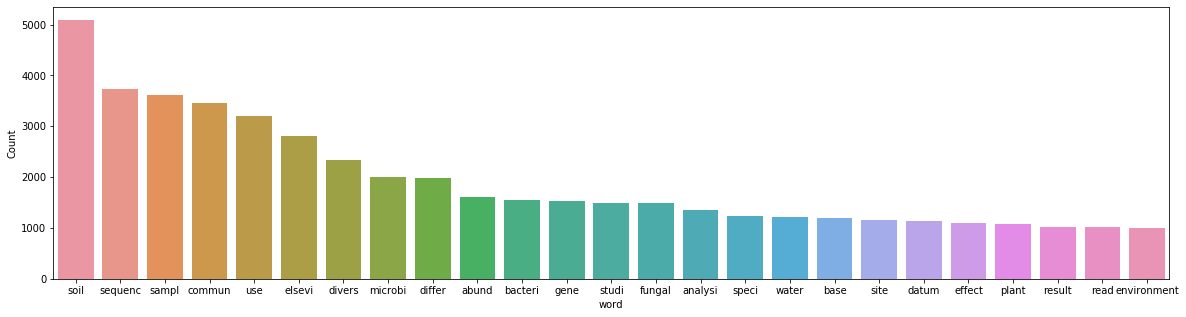

In [17]:
freqWordsGraph(words_df, 25, filename='unfiltered_training_words.png')

In [20]:
def createDict(words, freq):
    # Create Dictionary
    id2word = corpora.Dictionary(words)
    id2word.filter_extremes(no_below = freq)
    # Term Document Frequency
    corpus = [id2word.doc2bow(word) for word in words]
    return(id2word, corpus)

id2word, corpus = createDict(filt_Dwords, 5)

In [21]:
#ldamodel for a single model. Used more as a trial run to test timing for the creation
#for a particular topic number, and vary other parameters. 
#Precursor to the comput_eval_value function below
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
lda_model.show_topics()

In [22]:
def compute_eval_values(dictionary, corpus, texts, limit, start=2, step=5):
    """
        Compute c_v coherence and perplexity for various number of topics

        Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

        Returns:
        -------
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
        perplexity_values
    """
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_values

In [23]:
model_list, coherence_values, perplexity_values = compute_eval_values(dictionary=id2word, corpus=corpus, texts=trainDwords, start=2, limit=10, step=1)

In [24]:
# Compute Coherence Score of a singular model, precursor to the compute_eval_function
coherence_model_lda = CoherenceModel(model=model_list[2], texts=filt_Dwords, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3881924298479195


In [26]:
#These will save the model to the desktop for later use, if necesary
model_list[1].save('cneoformans_3kmodel')
model_list[2].save('cneoformans_4kmodel')

In [27]:
def evalsGrapher(coherences, perplexities, limit, start, step, filename):
    '''
    Function that graphs the coherences and perplexities of the previous function
    '''
    #clear other plot
    #plt.clf()
    #plt.cla()
    
    x = range(start, limit, step)
    for m, cv, pv in zip(x, coherences, perplexities):
        print("Num Topics =", m, "has a Coherence Value of ", round(cv, 4), " and has Perplexity Value of", round(np.exp(-1. * pv), 4))
    
    # Graph coherence and perplexity over kTopics
    fig, axs = plt.subplots(2,1, sharex=True)
    plt.xlabel("Num Topics")
    axs[0].plot(x, coherence_values, color='green')
    axs[0].set_ylabel("Coherence score")
    axs[0].legend(title ="Coherence", loc='best')

    axs[1].plot(x, perplexity_values, color='blue')
    axs[1].set_ylabel("Perplexity score")
    axs[1].legend(title="Perplexity", loc='best')
    
    #graphSaver(filename)
    plt.show()

Num Topics = 2 has a Coherence Value of  0.3891  and has Perplexity Value of 1382.9761
Num Topics = 3 has a Coherence Value of  0.4397  and has Perplexity Value of 1294.4076
Num Topics = 4 has a Coherence Value of  0.389  and has Perplexity Value of 1279.2354
Num Topics = 5 has a Coherence Value of  0.3687  and has Perplexity Value of 1274.6174
Num Topics = 6 has a Coherence Value of  0.3707  and has Perplexity Value of 1259.8227
Num Topics = 7 has a Coherence Value of  0.3714  and has Perplexity Value of 1243.132
Num Topics = 8 has a Coherence Value of  0.3672  and has Perplexity Value of 1216.3253
Num Topics = 9 has a Coherence Value of  0.3863  and has Perplexity Value of 1216.0913


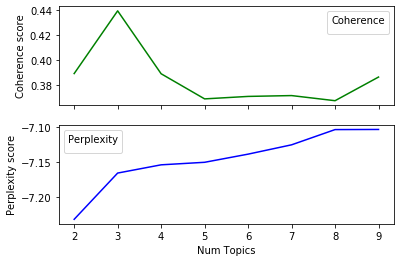

In [28]:
evalsGrapher(coherence_values, perplexity_values, 10, 2, 1, filename='coh-perp-plots.png')

In [29]:
def wordCountImpMaker(model, data, filename):
    '''
    Function to display word count and weight of each word for each topic
    Good visual indicator for analysis
    Input is the model, 2d list of words, and a filename to save to
    '''
    topics = model.show_topics(formatted=False)
    data_flat = [w for w_list in data for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(1, 3, figsize=(14,5), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05) 
    
    #graphSaver(filename)
    plt.show()

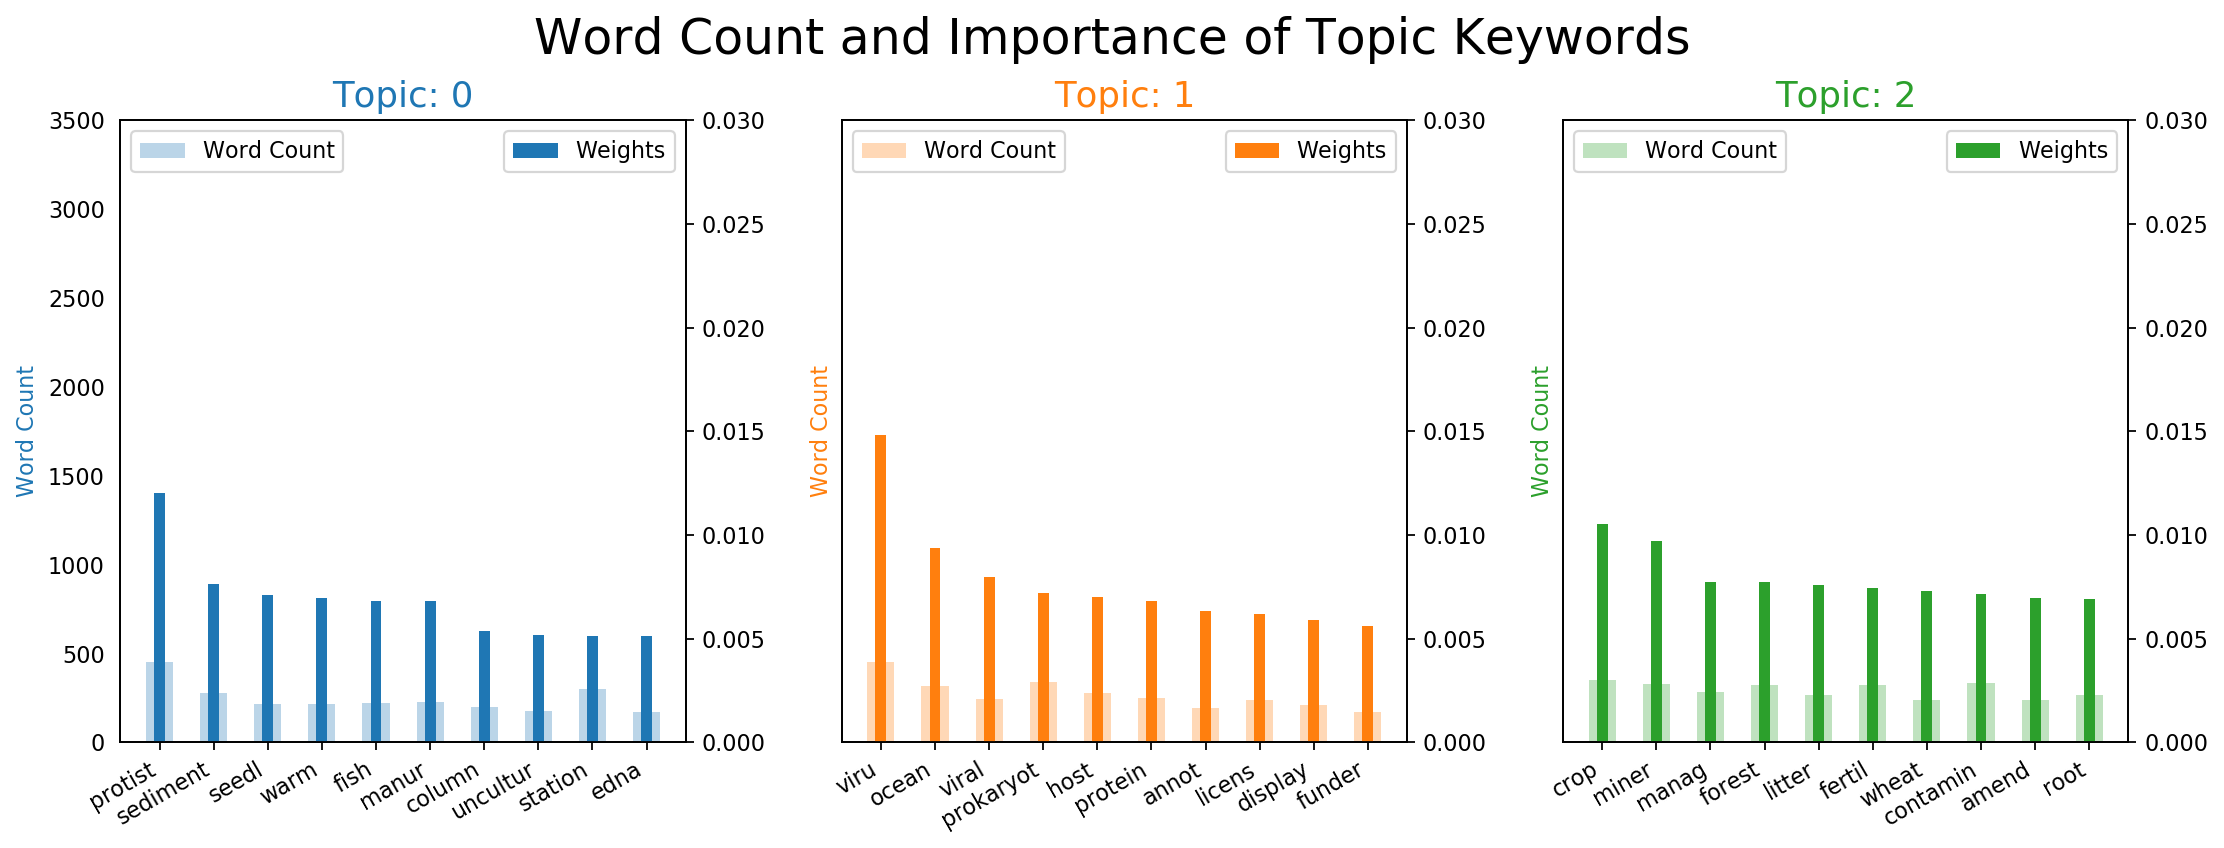

In [30]:
from collections import Counter
import matplotlib.colors as mcolors
wordCountImpMaker(model_list[1], filt_Dwords, filename='word-importance-graph-3k.png')

In [47]:
import pyLDAvis
import pyLDAvis.gensim
#Visualizaton of topics in an html format for more analysis purposes
lda_display = pyLDAvis.gensim.prepare(model_list[1], corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

In [29]:
pyLDAvis.save_html(lda_display, 'lda_4k_vis.html')

#Processing for testing corpus

In [31]:
testD = dataCleaning(testingData)
testDwords = list(sent_to_words(testD))
freqTestwords, wordsTestDf = wordsPreAnalysis(testDwords)

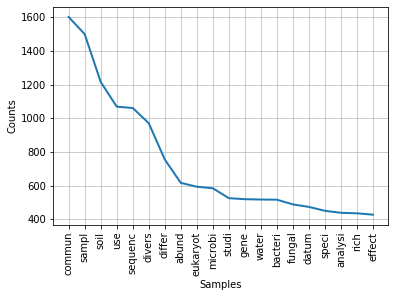

,word,count
1404,breadth,4
5018,decontamin,4
5023,conidia,4
3705,ganism,4
1914,touch,4
3704,microor,4
2051,thermoclin,4
539,ideal,4
2032,mett,4
5045,glycerol,4


In [32]:
freqTestwords.plot(20)
dflist = wordsTestDf.sort_values(by=["count"], ascending=False)
dflist[dflist["count"] < 5].head(30)

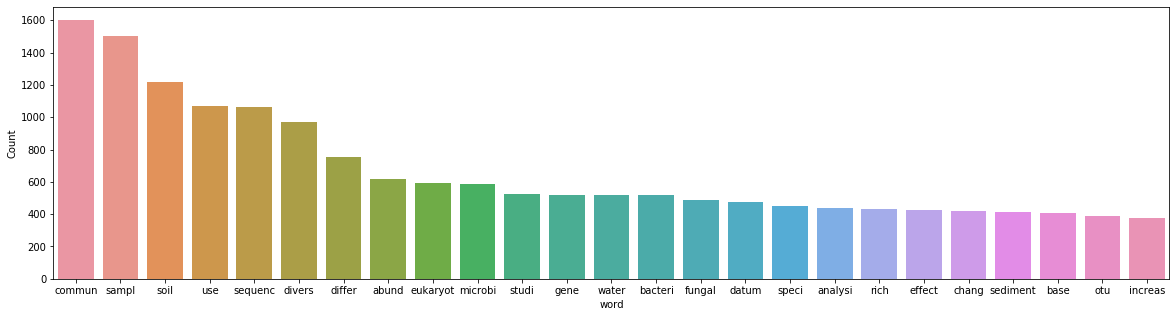

In [32]:
freqWordsGraph(wordsTestDf, 25, filename='unfiltered_test_words.png')

In [33]:
id2wordTest, corpusTest = createDict(testDwords, 5)

In [34]:
def format_topics_sentences(model, corpus, texts, kTopics):
    '''
    Function for grabbing topics and probabilities from lda model
    First part in process to export values to csvs
    Inputs are the model, text corpus, 2d list of words, and number of topics
    '''
    # Initialize dataframe to return and empty list
    sent_topics_df = pd.DataFrame()
    series_list=[]
    
    for i in range(kTopics):
        series_list.append(0)
    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            wp = model.show_topic(topic_num)
            series_list[topic_num]=prop_topic
            #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        sent_topics_df=sent_topics_df.append(pd.Series([series_list[i] for i in range(len(series_list))]), ignore_index=True)

    
    #sent_topics_df.columns = ['Topic_0', 'Topic_1', 'Topic_2']
    # Add original text to the end of the output
    sent_topics_df['contents'] = texts
    return(sent_topics_df)

In [35]:
def topicProbs2csv(df, labelList, nameList, kTopics, filename):
    '''
    Function to send topic probabilities to csv file
    '''
    
    df['label'] = labelList
    df['name'] = nameList
    
    # Show
    names = ['topic_{}'.format(i) for i in range(len(df.columns.values.tolist()) - 3)]+['contents', 'label', 'name'] 
    df.columns = names
    
    # Below we pull into the csv only the columns associated with the topics
    # and the labels. (this is the first kTopics columns and the second column from the end
    csv = df[names[:kTopics]+[names[-2]]].copy().to_csv(filename, index=False)
    csv_printout = df[names[:kTopics]+[names[-2]]].copy().to_csv(index=False)
    #print(csv_printout)


In [36]:
df_topic_sents_keywords = format_topics_sentences(lda_model, corpus, filt_Dwords, 3)

In [37]:
df_testing_topic_keywords = format_topics_sentences(lda_model, corpusTest, testDwords, 3)

In [38]:
testCsvfile = 'ltg_3k_testing.csv'
testCsv = topicProbs2csv(df_testing_topic_keywords, testingLabelList, testingNameList, 3, testCsvfile)

topic_0,topic_1,topic_2,label
0.16098527610301971,0.8298672437667847,0.0,1
0.09183414280414581,0.8846297860145569,0.0235360749065876,1
0.07115461677312851,0.8977289199829102,0.03111644834280014,1
0.2990928888320923,0.6812385320663452,0.019668610766530037,1
0.03102707862854004,0.8211770057678223,0.1477958709001541,1
0.09729865938425064,0.7091382741928101,0.19356310367584229,0
0.2812146544456482,0.7013041377067566,0.017481202259659767,1
0.3149097263813019,0.6699073910713196,0.01518285647034645,0
0.3708627223968506,0.4954545199871063,0.13368277251720428,0
0.1592460572719574,0.5488893985748291,0.2918645739555359,0
0.14535830914974213,0.7383248805999756,0.11631674319505692,1
0.30379265546798706,0.6414729356765747,0.05473443120718002,1
0.14294549822807312,0.8211190700531006,0.03593546524643898,0
0.3679353892803192,0.546054482460022,0.08601012825965881,1
0.14411862194538116,0.7665814757347107,0.08929987996816635,1
0.21171151101589203,0.6886440515518188,0.09964441508054733,1
0.1471005380153656

In [39]:
trainCsvfile = 'ltg_3k_training.csv'
trainCsv = topicProbs2csv(df_topic_sents_keywords, trainingLabelList, trainingNameList, 3, trainCsvfile)

topic_0,topic_1,topic_2,label
0.0,0.9998708963394165,0.0,1
0.0,0.9999443888664246,0.0,1
0.0,0.9693408012390137,0.030622174963355064,1
0.1715291291475296,0.8283842206001282,0.030622174963355064,1
0.1715291291475296,0.9999377131462097,0.030622174963355064,1
0.059916067868471146,0.7604476809501648,0.17963622510433197,0
0.059916067868471146,0.7604476809501648,0.999940037727356,0
0.999882161617279,0.7604476809501648,0.999940037727356,0
0.999882161617279,0.5414043068885803,0.45832908153533936,0
0.10902736335992813,0.5414043068885803,0.8909096717834473,1
0.8455619812011719,0.07175414264202118,0.08268386125564575,1
0.8455619812011719,0.07175414264202118,0.999922513961792,0
0.22947430610656738,0.06204633414745331,0.7084793448448181,0
0.22947430610656738,0.2255699783563614,0.7743624448776245,0
0.22947430610656738,0.2255699783563614,0.9999135732650757,1
0.22947430610656738,0.9998612403869629,0.9999135732650757,1
0.22947430610656738,0.9998955726623535,0.9999135732650757,1
0.22947430610656738,0.999

In [39]:
df_4test_topkeywords = format_topics_sentences(model_list[2], corpusTest, testDwords, 4)
df_4train_topkeywords = format_topics_sentences(model_list[2], corpus, filt_Dwords, 4)

In [40]:
testCsvfile = 'ltg_4k_testing.csv'
testCsv = topicProbs2csv(df_4test_topkeywords, testingLabelList, testingNameList, 4, testCsvfile)
trainCsvfile = 'ltg_4k_training.csv'
trainCsv = topicProbs2csv(df_4train_topkeywords, trainingLabelList, trainingNameList, 4, trainCsvfile)

topic_0,topic_1,topic_2,topic_3,label
0.09292693436145782,0.721565842628479,0.02623673528432846,0.1592704951763153,0
0.11791697144508362,0.8103600740432739,0.047793712466955185,0.023929262533783913,0
0.11791697144508362,0.7850203514099121,0.07528664171695709,0.13959956169128418,0
0.26241743564605713,0.6565062403678894,0.045324135571718216,0.035752203315496445,0
0.03796480596065521,0.77587890625,0.12697327136993408,0.05918300524353981,0
0.10734539479017258,0.619012176990509,0.20697486400604248,0.06666754186153412,1
0.32185831665992737,0.5996778607368469,0.20697486400604248,0.07104874402284622,0
0.12569692730903625,0.5476213693618774,0.03707512468099594,0.28960660099983215,1
0.3252429664134979,0.40841761231422424,0.14030393958091736,0.12603545188903809,1
0.21864160895347595,0.4127071797847748,0.18931163847446442,0.17933954298496246,1
0.21233578026294708,0.6303086280822754,0.10607820749282837,0.051277417689561844,0
0.18497812747955322,0.5004857182502747,0.10607820749282837,0.3086382746696

In [40]:
def getDominantTopics(ldamodel, corpus, texts, docname, labelList):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    docnames = pd.Series(docname)
    labelList = pd.Series(labelList)
    sent_topics_df = pd.concat([sent_topics_df, contents, docnames, labelList], axis=1)
    return(sent_topics_df)

In [41]:
#3 topic version, make a 4 topic version
df_getting_dom_topics = getDominantTopics(ldamodel=model_list[1], corpus=corpus, texts=filt_Dwords, 
                                          docname=trainingNameList, labelList=trainingLabelList)

In [42]:
# Format
df_dominant_topic = df_getting_dom_topics.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Document', 'Label']
display(df_dominant_topic.sort_values(['Dominant_Topic', 'Label']).head(60))

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document,Label
7,7,0.0,0.9999,"protist, sediment, seedl, warm, fish, manur, c...","[metabarcod, reveal, environment, factor, infl...",Brannock_2016_neg_18S_NoMenNeo.txt,0
18,18,0.0,0.7709,"protist, sediment, seedl, warm, fish, manur, c...","[aquat, publish, onlin, introduct, life, water...",Graupner_2017_neg_ITS2_and_18S_NoMenNeo.txt,0
22,22,0.0,0.9782,"protist, sediment, seedl, warm, fish, manur, c...","[environment, driver, spatial, variat, bacteri...",Hoffman_2018_neg_18S_NoMenNeo.txt,0
24,24,0.0,0.9461,"protist, sediment, seedl, warm, fish, manur, c...","[mediat, direct, strength, planta, soil, feedb...",Kadowaki_2018_neg_ITS2_NoMenNeo.txt,0
36,36,0.0,0.9999,"protist, sediment, seedl, warm, fish, manur, c...","[microbi, effect, livestock, manur, fertil, aq...",PRJEB24881_Minich_2018.txt,0
39,39,0.0,0.8161,"protist, sediment, seedl, warm, fish, manur, c...","[deep, branch, novel, lineag, divers, uncov, p...",PRJEB5541_Egge_2015.txt,0
65,65,0.0,0.9391,"protist, sediment, seedl, warm, fish, manur, c...","[environ, publish, introduct, aquacultur, proj...",PRJNA314454_Pawlowski_2016.txt,0
75,75,0.0,0.6308,"protist, sediment, seedl, warm, fish, manur, c...","[submit, accept, publish, correspond, author, ...",PRJNA369002_Laroche_2017.txt,0
82,82,0.0,0.9999,"protist, sediment, seedl, warm, fish, manur, c...","[map, distribut, cyst, recent, dinoflagel, coc...",PRJNA397358_Won-Jung_2018.txt,0
10,10,0.0,0.8455,"protist, sediment, seedl, warm, fish, manur, c...","[microorgan, persist, record, depth, subseaflo...",Ciobanu_2014_pos_ITS2_NoMenNeo.txt,1


In [43]:
df_examine =df_dominant_topic[['Dominant_Topic','Topic_Perc_Contrib', 'Keywords', 'Document', 'Label']]
df_examine.sort_values(['Dominant_Topic', 'Label'])

df_examine[['Dominant_Topic', 'Document', 'Label']].to_csv('training-docWordTopics-3k.csv')

In [ ]:
#BIGRAMS AND TRIGRAMS DO NOT WORK. UNIGRAM ONLY.
#not entirely sure about nthreshold
# Build the bigram and trigram models
#nthreshold=100
#bigram = gensim.models.Phrases(data_words, min_count=5, threshold=nthreshold) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=nthreshold)  

# Faster way to get a sentence clubbed as a trigram/bigram
#bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
'''
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
trainDwords_vec = vectorizer.fit_transform(filt_words)

GRID SEARCH TAKES TOO LONG, BUT WOULD BE GREAT TO IMPLEMENT
# Define Search Param
search_params = {'n_components': [1,2,3]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

model.fit(trainDwords_vec)

# Best Model
#best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))
'''